# Approximate Bayesian Computation (ABC)

***

Michael Burkhardt, Fabian Kessler, Dominik Straub

<img src="img/stochastic_simulator.png" style="max-width: 80%; width: 50%">

# Recap: Basic idea

> $p(\mathbf{\theta} \, | \, \mathbf x_{obs}) = \frac{p(\mathbf x_{obs} \, | \, \mathbf{\theta}) \: p(\mathbf{\theta})}{p(\mathbf x_{obs})}$



<font color="darkred"><strong>Problem</strong></font>: likelihood intractable or too expensive

* data-generating process can still be simulated
* bypass likelihood evaluation by simulating data
* accept parameter values for which simulated data are close to observed data

# Rejection ABC
<img src="img/concept1.png" style="max-width:100%; width: 50%"/>

<img src="img/concept2.png" style="max-width:100%; width: 50%"/>

<img src="img/concept3.png" style="max-width:100%; width: 50%"/>

<font color="darkred"><strong>Possible problems of Rejection ABC</strong></font>:
*** 
- choice of $\epsilon$ is crucial
- small $\epsilon$ lead to very high rejection rates $\Rightarrow$ acceptance rate of only 1% or less
- hugh problems when prior and likelihood are far apart
- only feasable if simulation process is very cheap
- what are good sufficient summary statistics
- curse of dimensionality

# Sequential Monte Carlo ABC
<img src="img/smcabc.png" style="max-width:100%; width: 70%"/>

<font color="darkred"><strong>Possible problems of SMC ABC</strong></font>:
***
- choice and number of $\epsilon$ is still crucial
- $\epsilon$ has to be choosen manually in a way that allows the algorithm to smoothly progress towards the region of high density

<img src="img/scope_without_ticks.png" style="max-width:100%; width: 60%"/>

<font align="left" color="darkblue" size="6" style="font-family: 'Helvetica'; line-height:1.2em;">Lets explore what we have done so far</font>

***

<font align="right" color="darkblue" size="5" style="font-family: 'Helvetica'; line-height: 1.1em;">And what you can do with our package</font>

# Toy example


In [18]:
import scipy.stats as ss
import pylab as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.plots import plot_marginals

%matplotlib notebook

<IPython.core.display.Javascript object>


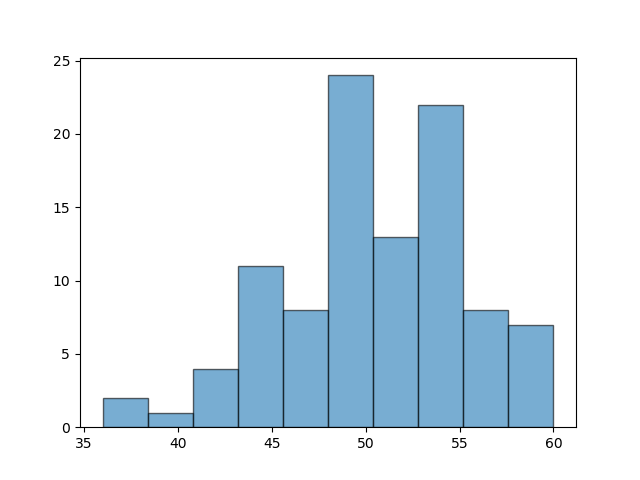

<IPython.core.display.Javascript object>


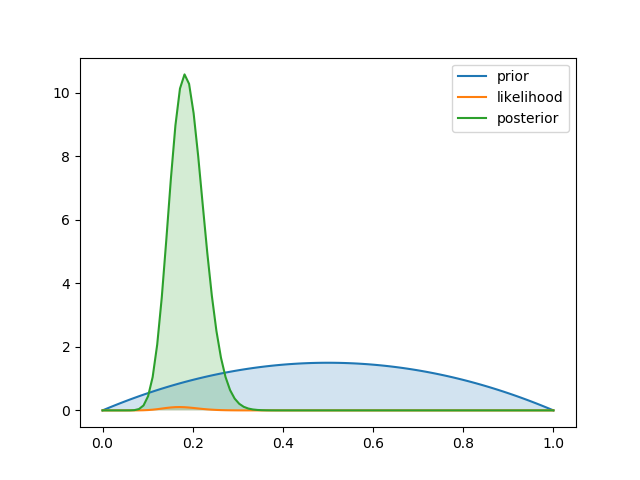

In [21]:
# create beta prior and likelihood and posterior
N = 100
prior = ss.beta(2,2)
likelihood = lambda p: ss.binom(N, p)
posterior = lambda x: ss.beta(a + x, b + N - x)

# create simulator
def simulator(p, size=1):
    global N
    return ss.binom(N, p).rvs(size)

plt.figure()
plt.hist(simulator(0.5, N), alpha=0.6, edgecolor="k")
plt.show()

# observation
X = simulator(0.2)

# true posterior: beta(a + sum x, b + sum N - sum x)
a, b = 3,3

plt.figure()
x = np.linspace(0,1, 100)

y = prior.pdf(x)
plt.plot(x,y, label="prior")
plt.fill_between(x, y1=0, y2=y, alpha=0.2)

y = likelihood(x).pmf(X)
plt.plot(x,y, label="likelihood")
plt.fill_between(x, y1=0, y2=y, alpha=0.2)

y = posterior(X).pdf(x)
plt.plot(x,y, label="posterior")
plt.fill_between(x, y1=0, y2=y, alpha=0.2)

plt.legend()
plt.show()

Rejection sampler started with threshold: 0 and number of samples: 1000
Samples:   1000 - Threshold: 0.0000 - Iterations:     111000 - Acceptance rate: 0.009009 - Time:    99.10 s


<IPython.core.display.Javascript object>


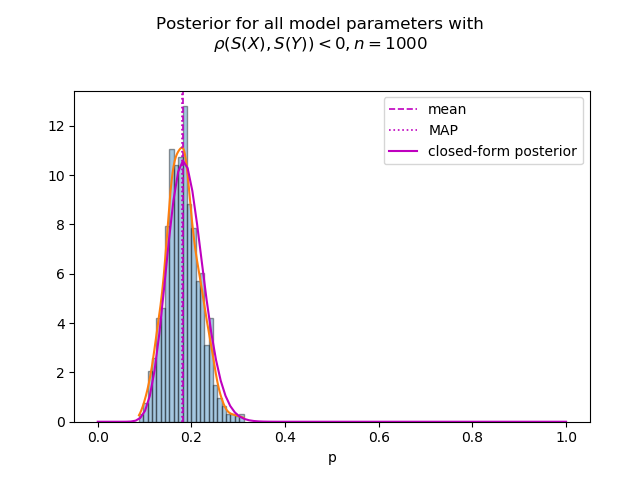

In [22]:
# now ABC
# create prior
prior = pyabc.Prior("beta", 2, 2, name="p")

# what can you do with it? sample, pdf

# create sampler
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator, summaries=lambda x: x, observation=X)

# sample
rej.sample(nr_samples=1000, threshold=0)

# plot marginals and posterior
plot_marginals(rej)
x = np.linspace(0,1, 100)
y = posterior(X).pdf(x)
plt.plot(x,y, "-m", label='closed-form posterior')
plt.legend()

In [20]:
mcmc = pyabc.MCMCSampler(priors=prior, simulator=simulator, summaries=lambda x: x, observation=X)
mcmc.sample(nr_samples=3000, threshold=0, step_size=[0.1])
plot_marginals(mcmc)

x = np.linspace(0,1, 100)
y = posterior(X).pdf(x)
plt.plot(x,y, "-m", label="closed_form posterior")
plt.legend()

False


TypeError: Passed argument [<scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5a16c9f438>] is not a subclass of prior!

# Clinic example

In [ ]:
# some code

# Mixture of 2 Gaussians
Let's consider an example, where the likelihood is a mixture of two Gaussians with a common mean $\theta$, equal weights and different (fixed) variances:

$$f(x | \theta) = 0.5 * \mathcal{N}(x | \theta, 1) + 0.5 * \mathcal{N}(x | \theta, 0.01)$$

and the prior is uniform: $p(\theta) = \mathcal{U}(-10, 10)$

The posterior is then given as:

<IPython.core.display.Javascript object>


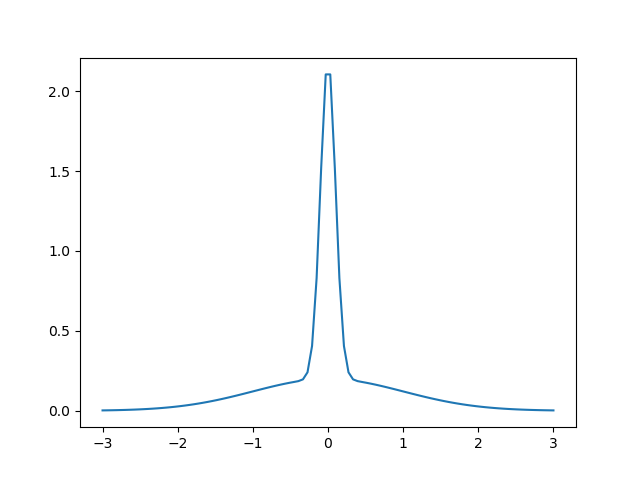

In [4]:
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, 0.1)

x = np.linspace(-3, 3, 100)
plt.figure()
plt.plot(x, posterior(x))
plt.show()

In the ABC setting, drawing from the posterior, can be realized by sampling from the standard normal distribution and then using the following distance function:

In [5]:
prior = pyabc.Prior('uniform', -10, 20, name='mu')
prior.sample()

def simulator(mu):
    return np.random.normal(mu, 1, size=100)

summary = lambda x: x
    
def rho(y, x):
    if np.random.rand() < 0.5:
        #print(np.abs(x.mean()))
        rho = np.abs(x.mean())
    else:
        #print(np.abs(x[0]))
        rho = np.abs(x[0])
    return rho

y0 = np.array([0.])


# Rejection-ABC

In [6]:
rej = pyabc.RejectionSampler(priors=[prior], simulator=simulator, 
                             summaries=[summary], distance=rho,
                             observation=y0)

rej.sample(nr_samples=1000, threshold=0.025)

Rejection sampler started with threshold: 0.025 and number of samples: 1000
Samples:   1000 - Threshold: 0.0250 - Iterations:     390000 - Acceptance rate: 0.002564 - Time:    12.78 s


<IPython.core.display.Javascript object>


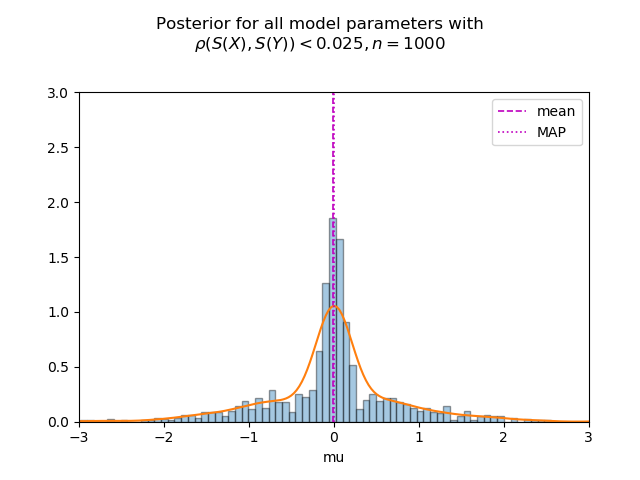

In [7]:
plot_marginals(rej, xlim=[(-3,3)], ylim=(0,3))

# MCMC-ABC

In [12]:
mcmc = pyabc.MCMCSampler(priors=[prior], simulator=simulator, 
                         summaries=[summary], distance=rho,
                         observation=y0)
mcmc.sample(nr_samples=10_000, threshold=0.025, step_size=[0.15**2])

MCMC sampler started with threshold: 0.025 and number of samples: 10000
Samples:  10000 - Threshold: 0.0250 - Iterations:     253877 - Acceptance rate: 0.039389 - Time:   102.86 s


<IPython.core.display.Javascript object>


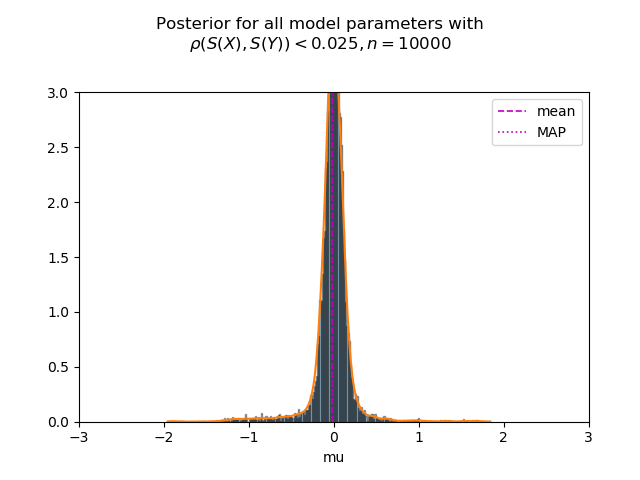

In [13]:
plot_marginals(mcmc, xlim=[(-3,3)], ylim=(0,3))

# BOLFI (Gutmann & Corander, 2016)

Why is ABC so expensive?
* It rejects lots of samples when $\epsilon$ is small
* It makes no assumptions about the form of the likelihood
* It does not use all information available
* It aims at equal accuracy for the whole parameter space

What can we do about this?
* Learn from rejected samples
* Model the distances, assume smoothness
* Use Bayes' Theorem to update the model
* Prioritize parameter regions that produce small distances

<img src="img/bolfi.png" style="max-width:100%; width: 90%"/>

# Outlook / report

In [2]:
# what comes next?